<a href="https://colab.research.google.com/github/olgaminguett/ET5003_SEM1_2021-2/blob/main/Week-5/ET5003_KaggleCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_KaggleCompetition

In [1]:
#@title Current Date
Today = "2021-10-18" #@param {type:"date"}

In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Team_Number = "Group 1" #@param {type:"string"}
StudentID_Name = "20179766 - Olga Minguett" #@param {type:"string"}
StudentID_Name = "" #@param {type:"string"}
StudentID_Name = "" #@param {type:"string"}
StudentID_Name = "" #@param {type:"string"}
StudentID_Name = "" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Assignment' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

- The goal is to use advanced Machine Learning methods to predict House prices in County Dublin, Ireland. 
- The development of this goal should be done using a small dataset created with descriptive features about the properties that could influence house prices, such as Location, Num_Bathrooms,Num_Beds, BER_class, Description,Services, Features,Latitude,Longitude,Type,Surface,Price
- The main advanced Machine Learning methods include Piecewise regression and Bayesian NN.

## Imports

In [4]:
!pip install GPy

In [5]:
# Regular expression operations
#https://docs.python.org/3/library/re.html
import re 

# standard libraries
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn is an open source machine learning library 
# that supports supervised and unsupervised learning
# https://scikit-learn.org/stable/
# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import *
from sklearn.pipeline import Pipeline

# Natural Language Toolkit
# https://www.nltk.org/install.html
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Stemming maps different forms of the same word to a common “stem” 
# https://pypi.org/project/snowballstemmer/
from nltk.stem import SnowballStemmer

# https://www.nltk.org/book/ch02.html
from nltk.corpus import stopwords

import GPy as GPy
import pylab as pb
import pymc3 as pm
import arviz as az
from google.colab import files

# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-CS6134/CS6134_SEM1_2021-2/tree/main/Week-5). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Load Data

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Path, copy the path from your Drive
syntPath = '/content/drive/My Drive/Colab Notebooks/house-data/'

In [9]:
# House Data
house_train = syntPath + 'HousePrice_Train.csv'
house_test = syntPath + 'HousePrice_Test.csv'
sample_submission = syntPath + 'sample_submission.csv'

In [10]:
# Read datasets
house_train = pd.read_csv(house_train).drop(columns="ID")
house_test = pd.read_csv(house_test).drop(columns="ID")
sample_submission = pd.read_csv(sample_submission)

## Explore Data

In [11]:
print("Training data shape", house_train.shape)
print("Test data shape", house_test.shape)

Training data shape (1638, 13)
Test data shape (702, 12)


In [12]:
# Print sample rows of the dataframe
house_train.sample(3)

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
1527,1528,Swords,2,3,C2,Important Note: To see the current highest off...,"Parking,Gas Fired Central Heating,Alarm,Wired ...",Electricity connected in the garden shed\nWell...,53.445373,-6.244045,end-of-terrace,98.0,310000
838,839,Santry,1,3,G,Granahan Estates are pleased to present to the...,Parking,Close proximity to bus routes\nExcellent renta...,53.391459,-6.234422,semi-detached,100.0,385000
424,425,Swords,3,4,D1,Sherry Fitzgerald are delighted to bring to th...,NaN,Excellent red brick detached residence\nPorche...,53.453984,-6.229010,detached,119.0,495000


In [13]:
# Print sample rows of the dataframe
house_test.sample(3)

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface
541,2180,Ringsend,1,2,G,Mason Estates are delighted to present 35 Hast...,NaN,Potential for refurbishment\nSouth facing cour...,53.341286,-6.233256,terraced,73.0
520,2159,Rush,3,3,C2,DNG McKenna Healy are delighted to present thi...,Gas Fired Central Heating,Sea Views \n Extended Kitchen \nIn Excelle...,53.527950,-6.092641,detached,151.1
227,1866,Kilmainham,2,2,B3,Stunning Fourth Floor Two-Bedroom Apartment wi...,"Parking,Gas Fired Central Heating,Wired for Ca...",Fourth Floor \nDesignated Underground Parking ...,53.342886,-6.309953,apartment,65.2


In [14]:
#Returns column name
print('Train Data Columns',house_train.columns)
print(len(house_train.columns))
print('Test Data Columns',house_test.columns)
print(len(house_test.columns))

Train Data Columns Index(['Index', 'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
       'Description', 'Services', 'Features', 'Latitude', 'Longitude', 'Type',
       'Surface', 'Price'],
      dtype='object')
13
Test Data Columns Index(['Index', 'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
       'Description', 'Services', 'Features', 'Latitude', 'Longitude', 'Type',
       'Surface'],
      dtype='object')
12


In [15]:
print('Train Data Shape',house_train.shape)
print('Test Data Shape',house_test.shape)

Train Data Shape (1638, 13)
Test Data Shape (702, 12)


The data consists in two datasets, train and test House Data, with 1638 by 13 vs 702 by 12 respectively. Only difference in columns numbers is the Price, as in this case is our target predictor. Information provided by the features include location, number of bathrooms and beds, BER class, description of the property, services, lat and long, type of property, size through surface and price. A column ID was dropped at loading data stage as it is another property identifier, as well as Index, and the former is the one used to recognize properties in the sample submission file, reason why it was kept.

In [16]:
#Concise summary of the dataframe
print('Train Data Information')
house_train.info()

Train Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638 entries, 0 to 1637
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          1638 non-null   int64  
 1   Location       1638 non-null   object 
 2   Num_Bathrooms  1638 non-null   int64  
 3   Num_Beds       1638 non-null   int64  
 4   BER_class      1387 non-null   object 
 5   Description    1638 non-null   object 
 6   Services       577 non-null    object 
 7   Features       1638 non-null   object 
 8   Latitude       1638 non-null   float64
 9   Longitude      1638 non-null   float64
 10  Type           1638 non-null   object 
 11  Surface        1638 non-null   float64
 12  Price          1638 non-null   int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 166.5+ KB


In [17]:
#Concise summary of the dataframe
print('Test Data Information')
house_test.info()

Test Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          702 non-null    int64  
 1   Location       702 non-null    object 
 2   Num_Bathrooms  702 non-null    int64  
 3   Num_Beds       702 non-null    int64  
 4   BER_class      594 non-null    object 
 5   Description    702 non-null    object 
 6   Services       246 non-null    object 
 7   Features       702 non-null    object 
 8   Latitude       702 non-null    float64
 9   Longitude      702 non-null    float64
 10  Type           702 non-null    object 
 11  Surface        702 non-null    float64
dtypes: float64(3), int64(3), object(6)
memory usage: 65.9+ KB


In [18]:
# Descriptive Statistics
house_train.describe()

,Index,Num_Bathrooms,Num_Beds,Latitude,Longitude,Surface,Price
count,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1.638000e+03
mean,819.500000,2.054335,3.043346,53.350473,-6.255086,169.540695,5.547196e+05
std,472.994186,1.241259,1.379650,0.076832,0.144430,1791.793934,5.652032e+05
min,1.000000,1.000000,1.000000,52.501856,-6.497000,3.400000,1.999500e+04
25%,410.250000,1.000000,2.000000,53.294261,-6.309613,73.000000,2.950000e+05
50%,819.500000,2.000000,3.000000,53.341386,-6.247780,97.050000,3.950000e+05
75%,1228.750000,3.000000,4.000000,53.382031,-6.193982,135.000000,5.950000e+05
max,1638.000000,18.000000,27.000000,53.630588,-1.744995,72236.387140,8.900000e+06


In [19]:
# Descriptive Statistics
house_test.describe()

,Index,Num_Bathrooms,Num_Beds,Latitude,Longitude,Surface
count,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000
mean,1989.500000,2.027066,2.987179,53.350445,-6.252411,132.603530
std,202.794231,1.071273,1.198480,0.073961,0.091600,330.347066
min,1639.000000,1.000000,1.000000,53.214227,-6.521183,32.100000
25%,1814.250000,1.000000,2.000000,53.295225,-6.304258,73.000000
50%,1989.500000,2.000000,3.000000,53.341153,-6.247799,99.200000
75%,2164.750000,3.000000,4.000000,53.381752,-6.184277,136.875000
max,2340.000000,9.000000,14.000000,53.617443,-6.057150,8576.000000


In [20]:
# Missing Values
print('Train Data Missing Values')
print(house_train.isna().sum())

Train Data Missing Values
Index               0
Location            0
Num_Bathrooms       0
Num_Beds            0
BER_class         251
Description         0
Services         1061
Features            0
Latitude            0
Longitude           0
Type                0
Surface             0
Price               0
dtype: int64


In [21]:
print('Test Data Missing Values')
print(house_test.isna().sum())

Test Data Missing Values
Index              0
Location           0
Num_Bathrooms      0
Num_Beds           0
BER_class        108
Description        0
Services         456
Features           0
Latitude           0
Longitude          0
Type               0
Surface            0
dtype: int64


In [22]:
#Percentage of NAN Values
print('Train Data Percentage of NAN Values')
print(house_train.isna().mean().round(4) * 100)

Train Data Percentage of NAN Values
Index             0.00
Location          0.00
Num_Bathrooms     0.00
Num_Beds          0.00
BER_class        15.32
Description       0.00
Services         64.77
Features          0.00
Latitude          0.00
Longitude         0.00
Type              0.00
Surface           0.00
Price             0.00
dtype: float64


In [23]:
print('Test Data Percentage of NAN Values')
print(house_test.isna().mean().round(4) * 100)

Test Data Percentage of NAN Values
Index             0.00
Location          0.00
Num_Bathrooms     0.00
Num_Beds          0.00
BER_class        15.38
Description       0.00
Services         64.96
Features          0.00
Latitude          0.00
Longitude         0.00
Type              0.00
Surface           0.00
dtype: float64


In [24]:
# Recognise any columns that have the same value in each at the start of the code
# Feedback from Nigel Portley 
columnlist = []
def is_unique(s):
    a = s.to_numpy()
    return (a[0] == a).all()

for column in house_train:
    if (is_unique(house_train[column]) == True): 
        print(column)
        columnlist.append(str(column))
print(columnlist)
#house_train.drop(columnlist, axis=1, inplace=True)

for column in house_test:
    if (is_unique(house_test[column]) == True): 
        print(column)
        columnlist.append(str(column))
print(columnlist)
#house_test.drop(columnlist, axis=1, inplace=True)

[]
[]


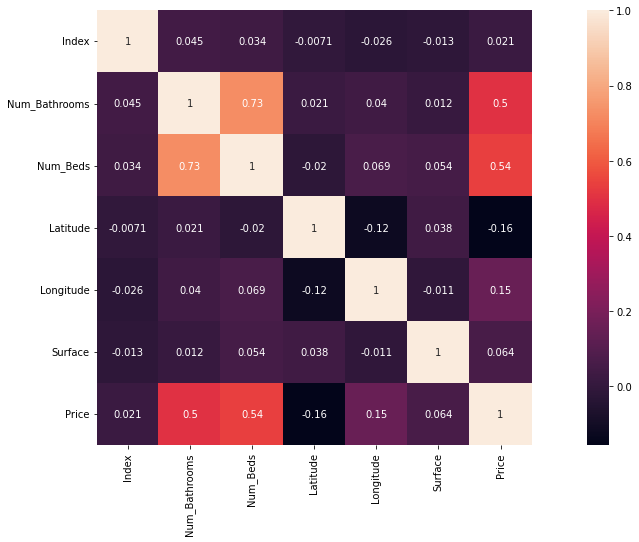

In [25]:
plt.figure(figsize=(20, 8))
sns.heatmap(house_train.corr(), square=True, annot=True);

For Missing Values, in the train dataset `BER_class` has 251 data points which represent ~15% and `Services` 1061 data points which is ~64%. In te other hand the test dataset `BER_class` has 108 data points which represent ~15% and `Services` 456 data points which is ~64%. Using part of the learnings from past etivity, none of the columns seem to have the same value. Futhermore, according to the Number of Bathrooms and Number of Beds, show the highest correlation of all of the features.

## Feature Engineering

'Index'

In [26]:
house_train['Index'].nunique()

1638

In [27]:
house_test['Index'].nunique()

702

Having 1638 and 702 unique values, corroborates Index as the property identifier, and one per property

'Location'

In [28]:
house_train['Location'].value_counts()

Castleknock    57
Malahide       50
Lucan          49
Rathfarnham    46
Clondalkin     41
               ..
Smithfield      1
Brittas         1
Ballymun        1
Deansgrange     1
Kingswood       1
Name: Location, Length: 142, dtype: int64

In [29]:
house_train['Location'].replace({'Temple Bar':'Dublin 1', 'IFSC':'Dublin 1', 
                            'Grand Canal Dock':'Dublin 2',
                            'Clontarf':'Dublin 3', 'East Wall':'Dublin 3', 'North Strand':'Dublin 3', 'Fairview':'Dublin 3', 'Marino':'Dublin 3', 'Ballyboughal':'Dublin 3', 
                            'Ballsbridge':'Dublin 4', 'Donnybrook':'Dublin 4','Sandymount':'Dublin 4','Ringsend':'Dublin 4','Irishtown':'Dublin 4','Merrion':'Dublin 4',
                            'Artane':'Dublin 5','Raheny':'Dublin 5','Kilbarrack':'Dublin 5','Edenmore':'Dublin 5','Kilmore':'Dublin 5','Donnycarney':'Dublin 5',
                            'Rathmines':'Dublin 6','Rathgar':'Dublin 6','Ranelagh':'Dublin 6','Milltown':'Dublin 6','Dartry':'Dublin 6',
                            'Stoneybatter':'Dublin 7','Phibsborough':'Dublin 7','Navan Road (D7)':'Dublin 7','North Circular Road':'Dublin 7','Smithfield':'Dublin 7','Ashtown':'Dublin 7','Cabra':'Dublin 7',
                            'Kilmainham':'Dublin 8','Inchicore':'Dublin 8','Rialto':'Dublin 8','Portobello':'Dublin 8','South Circular Road':'Dublin 8','Islandbridge':'Dublin 8','The Coombe':'Dublin 8',"Dolphin's Barn":'Dublin 8','Christchurch':'Dublin 8',
                            'Drumcondra':'Dublin 9','Glasnevin':'Dublin 9','Santry':'Dublin 9','Whitehall':'Dublin 9','Beaumont':'Dublin 9','Ballymun':'Dublin 9','Poppintree':'Dublin 9',
                            'Ballyfermot':'Dublin 10','Cherry Orchard':'Dublin 10',
                            'Finglas':'Dublin 11',"St Margaret's":'Dublin 11',
                            'Walkinstown':'Dublin 12','Crumlin':'Dublin 12','Drimnagh':'Dublin 12','Bluebell':'Dublin 12','Park West':'Dublin 12','Perrystown':'Dublin 12',
                            'Malahide':'Dublin 13','Howth':'Dublin 13','Sutton':'Dublin 13','Baldoyle':'Dublin 13','Donaghmede':'Dublin 13','Bayside':'Dublin 13','Ard Na Greine':'Dublin 13','Clongriffin':'Dublin 13','Clarehall':'Dublin 13',
                            'Dundrum':'Dublin 14','Churchtown':'Dublin 14','Goatstown':'Dublin 14','Clonskeagh':'Dublin 14','Windy Arbour':'Dublin 14',
                            'Carpenterstown':'Dublin 15','Castleknock':'Dublin 15','Clonsilla':'Dublin 15','Blanchardstown':'Dublin 15','Clonee':'Dublin 15','Coolmine':'Dublin 15','Hartstown':'Dublin 15','Mulhuddart':'Dublin 15','The Ward':'Dublin 15','Ongar':'Dublin 15','Tyrrelstown':'Dublin 15',
                            'Rathfarnham':'Dublin 16','Ballinteer':'Dublin 16','Ballinascorney':'Dublin 16','Knocklyon':'Dublin 16',
                            'Darndale':'Dublin 17','Clonshaugh':'Dublin 17','Coolock':'Dublin 17','Killester':'Dublin 17',
                            'Deansgrange':'Dublin 18','Sandyford':'Dublin 18','Foxrock':'Dublin 18','Stepaside':'Dublin 18','Cabinteely':'Dublin 18','Carrickmines':'Dublin 18','Leopardstown':'Dublin 18','Kilternan':'Dublin 18','Shankill':'Dublin 18',
                            'Palmerstown':'Dublin 20','Chapelizod':'Dublin 20','Lucan':'Dublin 20',
                            'Clondalkin':'Dublin 22','Kingswood':'Dublin 22','Newcastle':'Dublin 22',
                            'Ballymount':'Dublin 24','Kiltipper':'Dublin 24','Tallaght':'Dublin 24','Balrothery':'Dublin 24','Rathcoole':'Dublin 24','Kilnamanagh':'Dublin 24','Firhouse':'Dublin 24','Greenhills':'Dublin 24','Oldbawn':'Dublin 24','Adamstown':'Dublin 24','Saggart':'Dublin 24','Citywest':'Dublin 24','Ballycullen':'Dublin 24','Brittas':'Dublin 24',
                            'Terenure':'Dublin 6w',"Harold's Cross":'Dublin 6w','Kimmage':'Dublin 6w','Templeogue':'Dublin 6w',
                            'Donabate':'Fingal','Swords':'Fingal','Portmarnock':'Fingal','Kinsealy':'Fingal','Balgriffin':'Fingal','Garristown':'Fingal','Naul':'Fingal','Skerries':'Fingal','Rush':'Fingal','Lusk':'Fingal','Balbriggan':'Fingal','Loughshinny':'Fingal','Ballybough':'Fingal',
                            'Blackrock':'DunLaoghaireRathdown','Dun Laoghaire':'DunLaoghaireRathdown','Glenageary':'DunLaoghaireRathdown',
                            'Monkstown':'DunLaoghaireRathdown','Booterstown':'DunLaoghaireRathdown','Sandycove':'DunLaoghaireRathdown',
                            'Rathmichael':'DunLaoghaireRathdown','Mount Merrion':'DunLaoghaireRathdown','Ballybrack':'DunLaoghaireRathdown','Sallynoggin':'DunLaoghaireRathdown',
                            'Kilmacud':'DunLaoghaireRathdown','Dalkey':'DunLaoghaireRathdown','Killiney':'DunLaoghaireRathdown','Loughlinstown':'DunLaoghaireRathdown',
                            }, inplace=True)

In [30]:
house_train['Location'].value_counts()

DunLaoghaireRathdown    160
Fingal                  139
Dublin 15               117
Dublin 13               115
Dublin 24               104
Dublin 9                 97
Dublin 18                96
Dublin 4                 95
Dublin 16                80
Dublin 7                 69
Dublin 8                 65
Dublin 20                58
Dublin 6                 56
Dublin 14                55
Dublin 3                 55
Dublin 6w                48
Dublin 22                43
Dublin 5                 42
Dublin 1                 38
Dublin 11                32
Dublin 12                29
Dublin 2                 24
Dublin 17                17
Dublin 10                 4
Name: Location, dtype: int64

In [31]:
house_test['Location'].replace({'Temple Bar':'Dublin 1', 'IFSC':'Dublin 1', 
                            'Grand Canal Dock':'Dublin 2',
                            'Clontarf':'Dublin 3', 'East Wall':'Dublin 3', 'North Strand':'Dublin 3', 'Fairview':'Dublin 3', 'Marino':'Dublin 3', 'Ballyboughal':'Dublin 3', 
                            'Ballsbridge':'Dublin 4', 'Donnybrook':'Dublin 4','Sandymount':'Dublin 4','Ringsend':'Dublin 4','Irishtown':'Dublin 4','Merrion':'Dublin 4',
                            'Artane':'Dublin 5','Raheny':'Dublin 5','Kilbarrack':'Dublin 5','Edenmore':'Dublin 5','Kilmore':'Dublin 5','Donnycarney':'Dublin 5',
                            'Rathmines':'Dublin 6','Rathgar':'Dublin 6','Ranelagh':'Dublin 6','Milltown':'Dublin 6','Dartry':'Dublin 6',
                            'Stoneybatter':'Dublin 7','Phibsborough':'Dublin 7','Navan Road (D7)':'Dublin 7','North Circular Road':'Dublin 7','Smithfield':'Dublin 7','Ashtown':'Dublin 7','Cabra':'Dublin 7',
                            'Kilmainham':'Dublin 8','Inchicore':'Dublin 8','Rialto':'Dublin 8','Portobello':'Dublin 8','South Circular Road':'Dublin 8','Islandbridge':'Dublin 8','The Coombe':'Dublin 8',"Dolphin's Barn":'Dublin 8','Christchurch':'Dublin 8',
                            'Drumcondra':'Dublin 9','Glasnevin':'Dublin 9','Santry':'Dublin 9','Whitehall':'Dublin 9','Beaumont':'Dublin 9','Ballymun':'Dublin 9','Poppintree':'Dublin 9',
                            'Ballyfermot':'Dublin 10','Cherry Orchard':'Dublin 10',
                            'Finglas':'Dublin 11',"St Margaret's":'Dublin 11',
                            'Walkinstown':'Dublin 12','Crumlin':'Dublin 12','Drimnagh':'Dublin 12','Bluebell':'Dublin 12','Park West':'Dublin 12','Perrystown':'Dublin 12',
                            'Malahide':'Dublin 13','Howth':'Dublin 13','Sutton':'Dublin 13','Baldoyle':'Dublin 13','Donaghmede':'Dublin 13','Bayside':'Dublin 13','Ard Na Greine':'Dublin 13','Clongriffin':'Dublin 13','Clarehall':'Dublin 13',
                            'Dundrum':'Dublin 14','Churchtown':'Dublin 14','Goatstown':'Dublin 14','Clonskeagh':'Dublin 14','Windy Arbour':'Dublin 14',
                            'Carpenterstown':'Dublin 15','Castleknock':'Dublin 15','Clonsilla':'Dublin 15','Blanchardstown':'Dublin 15','Clonee':'Dublin 15','Coolmine':'Dublin 15','Hartstown':'Dublin 15','Mulhuddart':'Dublin 15','The Ward':'Dublin 15','Ongar':'Dublin 15','Tyrrelstown':'Dublin 15',
                            'Rathfarnham':'Dublin 16','Ballinteer':'Dublin 16','Ballinascorney':'Dublin 16','Knocklyon':'Dublin 16',
                            'Darndale':'Dublin 17','Clonshaugh':'Dublin 17','Coolock':'Dublin 17','Killester':'Dublin 17',
                            'Deansgrange':'Dublin 18','Sandyford':'Dublin 18','Foxrock':'Dublin 18','Stepaside':'Dublin 18','Cabinteely':'Dublin 18','Carrickmines':'Dublin 18','Leopardstown':'Dublin 18','Kilternan':'Dublin 18','Shankill':'Dublin 18',
                            'Palmerstown':'Dublin 20','Chapelizod':'Dublin 20','Lucan':'Dublin 20',
                            'Clondalkin':'Dublin 22','Kingswood':'Dublin 22','Newcastle':'Dublin 22',
                            'Ballymount':'Dublin 24','Kiltipper':'Dublin 24','Tallaght':'Dublin 24','Balrothery':'Dublin 24','Rathcoole':'Dublin 24','Kilnamanagh':'Dublin 24','Firhouse':'Dublin 24','Greenhills':'Dublin 24','Oldbawn':'Dublin 24','Adamstown':'Dublin 24','Saggart':'Dublin 24','Citywest':'Dublin 24','Ballycullen':'Dublin 24','Brittas':'Dublin 24',
                            'Terenure':'Dublin 6w',"Harold's Cross":'Dublin 6w','Kimmage':'Dublin 6w','Templeogue':'Dublin 6w',
                            'Donabate':'Fingal','Swords':'Fingal','Portmarnock':'Fingal','Kinsealy':'Fingal','Balgriffin':'Fingal','Garristown':'Fingal','Naul':'Fingal','Skerries':'Fingal','Rush':'Fingal','Lusk':'Fingal','Balbriggan':'Fingal','Loughshinny':'Fingal','Ballybough':'Fingal',
                            'Blackrock':'DunLaoghaireRathdown','Dun Laoghaire':'DunLaoghaireRathdown','Glenageary':'DunLaoghaireRathdown',
                            'Monkstown':'DunLaoghaireRathdown','Booterstown':'DunLaoghaireRathdown','Sandycove':'DunLaoghaireRathdown',
                            'Rathmichael':'DunLaoghaireRathdown','Mount Merrion':'DunLaoghaireRathdown','Ballybrack':'DunLaoghaireRathdown','Sallynoggin':'DunLaoghaireRathdown',
                            'Kilmacud':'DunLaoghaireRathdown','Dalkey':'DunLaoghaireRathdown','Killiney':'DunLaoghaireRathdown','Loughlinstown':'DunLaoghaireRathdown',
                            }, inplace=True)

In [32]:
house_test['Location'].value_counts()

DunLaoghaireRathdown    73
Fingal                  67
Dublin 13               44
Dublin 18               43
Dublin 9                43
Dublin 8                41
Dublin 15               40
Dublin 4                40
Dublin 16               37
Dublin 24               32
Dublin 7                29
Dublin 20               25
Dublin 3                22
Dublin 6w               21
Dublin 1                21
Dublin 14               20
Dublin 12               20
Dublin 5                17
Dublin 22               16
Dublin 6                16
Dublin 11               14
Dublin 2                10
Dublin 17                7
Dublin 10                4
Name: Location, dtype: int64

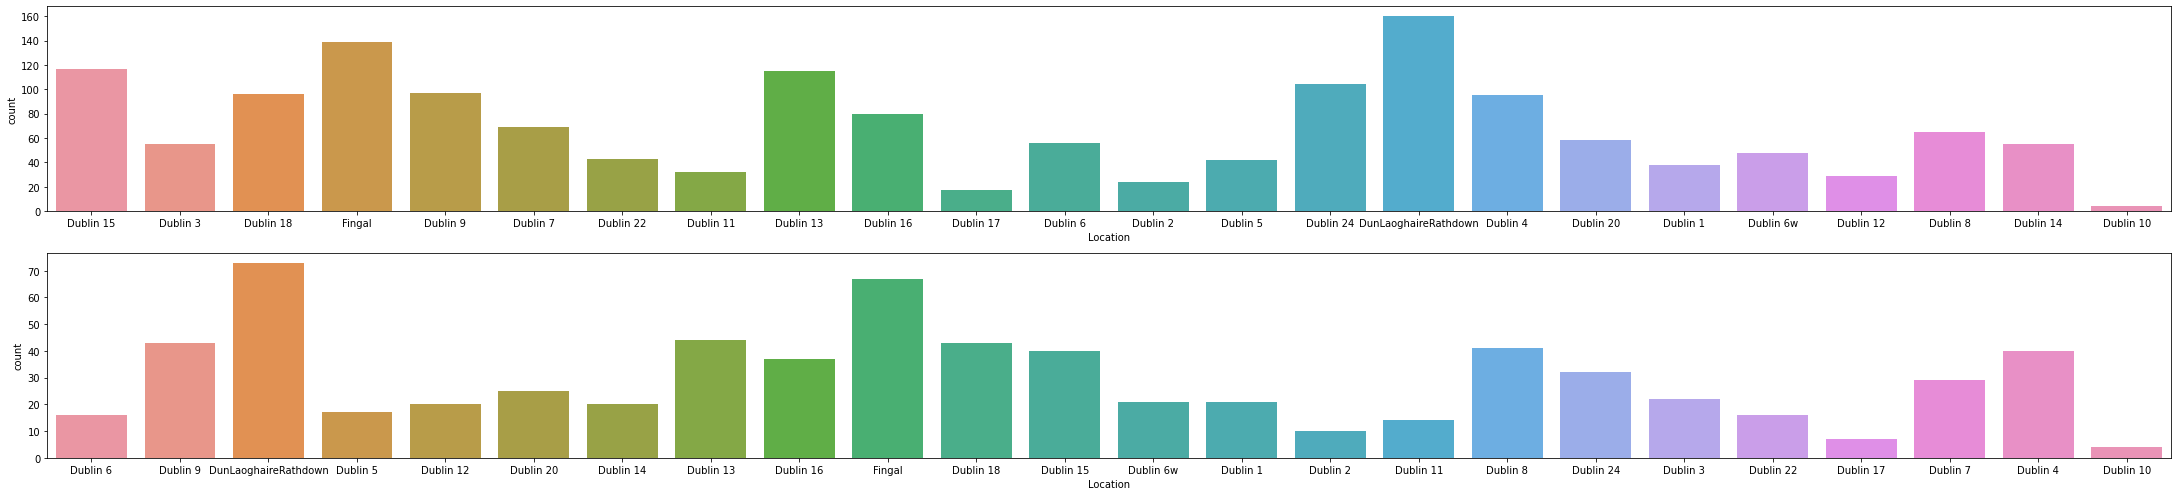

In [33]:
fig = plt.figure(figsize=(60,7))
fig.add_subplot(2,2,1)
sns.countplot(house_train['Location'])
fig.add_subplot(2,2,3)
sns.countplot(house_test['Location'])
plt.tight_layout()

In [34]:
# Get one hot encoding of columns area
one_hot = pd.get_dummies(house_train['Location'])
one_hot_ = pd.get_dummies(house_test['Location'])
# Drop column Area as it is now encoded
house_test = house_test.drop('Location', axis=1)
house_train = house_train.drop('Location', axis=1)
# Join the encoded dataframe
house_train = house_train.join(one_hot)
house_test = house_test.join(one_hot_)

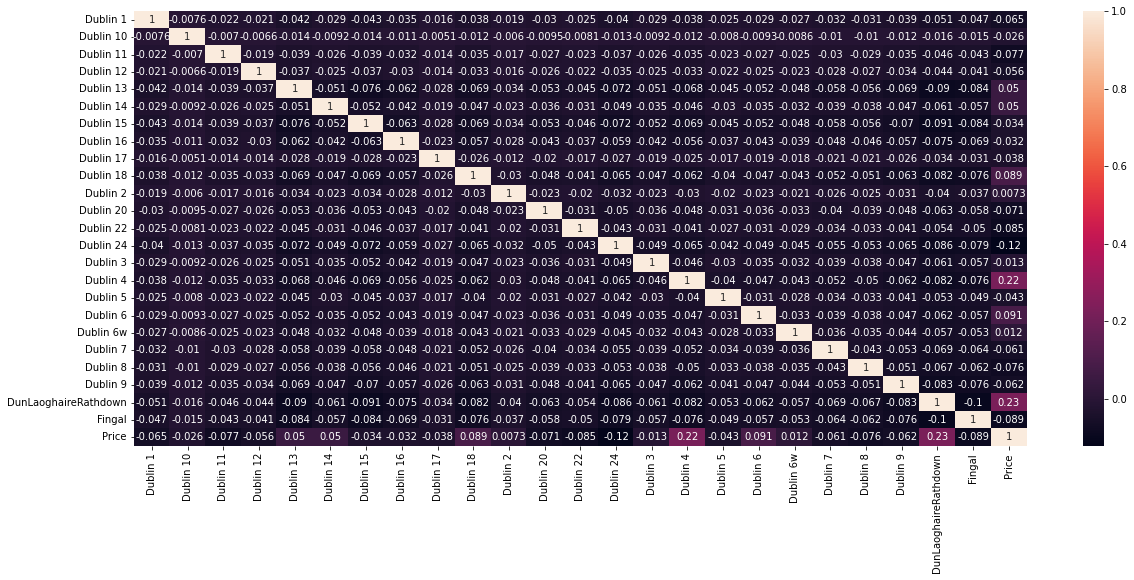

In [35]:
plt.figure(figsize=(20, 8))
sns.heatmap(house_train[['Dublin 1', 'Dublin 10', 'Dublin 11', 'Dublin 12', 'Dublin 13',\
                        'Dublin 14', 'Dublin 15', 'Dublin 16', 'Dublin 17', 'Dublin 18',\
                        'Dublin 2', 'Dublin 20', 'Dublin 22', 'Dublin 24', 'Dublin 3',\
                        'Dublin 4', 'Dublin 5', 'Dublin 6', 'Dublin 6w', 'Dublin 7', 'Dublin 8',\
                        'Dublin 9', 'DunLaoghaireRathdown', 'Fingal', 'Price']].corr(),annot=True);

In [36]:
location = ['Dublin 1', 'Dublin 10', 'Dublin 11', 'Dublin 12', 'Dublin 13',
            'Dublin 14', 'Dublin 15', 'Dublin 16', 'Dublin 17', 'Dublin 18',
            'Dublin 2', 'Dublin 20', 'Dublin 22', 'Dublin 24', 'Dublin 3',
            'Dublin 4', 'Dublin 5', 'Dublin 6', 'Dublin 6w', 'Dublin 7', 'Dublin 8',
                        'Dublin 9', 'DunLaoghaireRathdown', 'Fingal']
house_train.drop(location, axis=1, inplace=True)
house_test.drop(location, axis=1, inplace=True)

Using learning from the past etivity, Location was converted to numerical variables, replacing all characters, from various cities and towns in County Dublin, County Fingal and County Dun Laoghaire-Rathdown to the various Dublin and Counties that they are located. Being Dun Laoghaire and Fingal, the ones with the highest number of properties, follow by Dublin 9, 13 and 24 for the train dataset and 9, 13, and 18. Two from the Nort section of the city and one from the south side in each case. Followed by to a reconfiguration to the correspondent numerical value, when using get_dummies. After checking the correlation of every location individually against price, with no particular outstanding values to be kept, dropped consequently.

'Num_Bathrooms'

In [37]:
house_train['Num_Bathrooms'].value_counts()

1     603
2     584
3     327
4      76
5      24
6      11
7       6
8       3
15      2
18      1
9       1
Name: Num_Bathrooms, dtype: int64

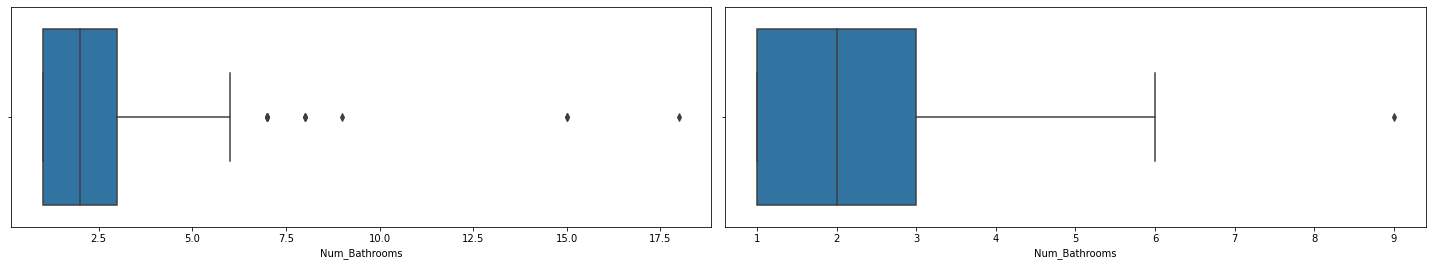

In [38]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(2,2,1)
sns.boxplot(x=house_train["Num_Bathrooms"])
fig.add_subplot(2,2,2)
sns.boxplot(x=house_test["Num_Bathrooms"])
plt.tight_layout()

In [39]:
house_train['Num_Bathrooms'].values[house_train['Num_Bathrooms'].values > 6 ] = 6
house_test['Num_Bathrooms'].values[house_test['Num_Bathrooms'].values > 6 ] = 6

Number of bathrooms was reconfigured to remove the outliers, having all a max of 6 bathrooms per property, having 1 as minimun.

'Num_Beds'

In [40]:
house_train['Num_Beds'].value_counts()

3     558
2     464
4     348
1     114
5     107
6      29
7      11
15      2
9       2
8       2
27      1
Name: Num_Beds, dtype: int64

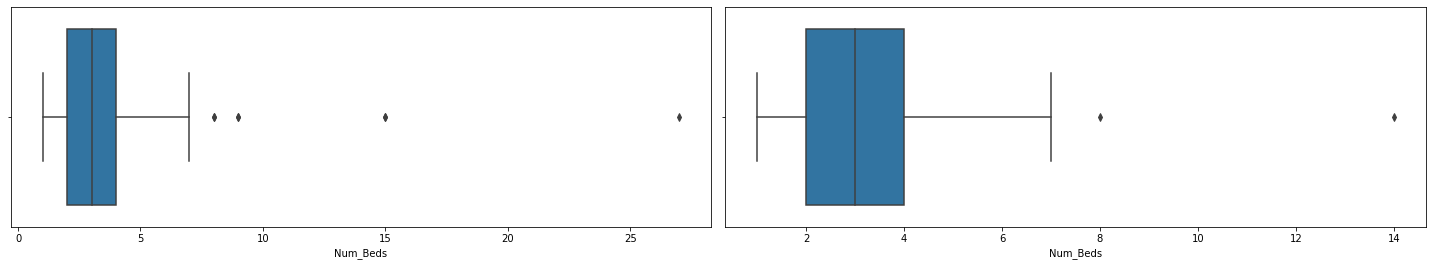

In [41]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(2,2,1)
sns.boxplot(x=house_train["Num_Beds"])
fig.add_subplot(2,2,2)
sns.boxplot(x=house_test["Num_Beds"])
plt.tight_layout()

In [42]:
house_train['Num_Beds'].values[house_train['Num_Beds'].values > 7 ] = 7
house_test['Num_Beds'].values[house_test['Num_Beds'].values > 7 ] = 7

Number of beds was reconfigured to remove the outliers, having all a max of 7 beds per property, having 1 as minimun.

'BER_class'

In [43]:
house_train['BER_class'].value_counts()

D1                     182
D2                     173
C3                     154
C2                     144
C1                     133
E1                     110
G                      103
E2                     101
F                       89
B3                      78
B2                      48
A3                      37
SINo666of2006exempt     15
A2                      12
B1                       7
A1                       1
Name: BER_class, dtype: int64

In [44]:
print("Train Dataset Missing Data:",house_train['BER_class'].isna().sum())
print("Test Dataset Missing Data:", house_test['BER_class'].isna().sum())

Train Dataset Missing Data: 251
Test Dataset Missing Data: 108


In [45]:
house_train['BER_class'].fillna('unknown', inplace=True)
house_test['BER_class'].fillna('unknown', inplace=True)

In [46]:
ber_classification_mapper = {
    "A1": 1,
    "A2": 2,
    "A3": 3,
    "B1": 4,
    "B2": 5,
    "B3": 6,
    "C1": 7,
    "C2": 8,
    "C3": 9,
    "D1": 10,
    "D2": 11,
    "E1": 12,
    "E2": 13,
    "F": 14,
    "G": 15,
    "SINo666of2006exempt": 16,
    "unknown": 17
}
house_train['BER_class'] = house_train['BER_class'].replace(ber_classification_mapper)
house_test['BER_class'] = house_test['BER_class'].replace(ber_classification_mapper)

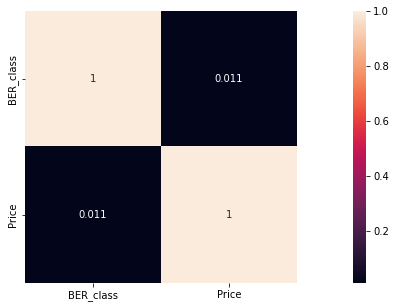

In [47]:
plt.figure(figsize=(20,5))
sns.heatmap(house_train[['BER_class', 'Price']].corr(), square=True, annot=True);

In [48]:
house_train.drop('BER_class', axis=1, inplace=True)
house_test.drop('BER_class', axis=1, inplace=True)

`BER_classification` contained ~15% of missing values that were filled up with Unknown, as they represent a significant amount that can modify other categories within it. They were converted to numerical variables, replacing the 17 characters. It doesn't seem to be a strong correlation between Proce and Ber Class, so feature is was dropped.

'Description'

In [49]:
house_train['Description'].head()

0    DNG are delighted to present to the market no....
1    13 Northbrook Terrace is a charming red brick ...
2    Welcome to No. 6 Cotter Close, an immaculately...
3    Welcome to 3 Sycamore Walk!\n\r\nEnjoying a pr...
4    'Four Seasons' comes to the market as a wonder...
Name: Description, dtype: object

`Description` is Free text, that will be processed using NLP

'Services'

In [50]:
house_train['Services'].value_counts()

Parking,Gas Fired Central Heating                                                               118
Parking                                                                                          77
Parking,Gas Fired Central Heating,Wired for Cable Television                                     74
Parking,Gas Fired Central Heating,Alarm,Wired for Cable Television                               62
Parking,Gas Fired Central Heating,Alarm                                                          57
Parking,Wired for Cable Television                                                               35
Gas Fired Central Heating                                                                        25
Parking,Oil Fired Central Heating                                                                12
Parking,Gas Fired Central Heating,Alarm,Wired for Cable Television,Wheelchair Access             12
Parking,Alarm                                                                                    12


In [51]:
house_train["Alarm"] = house_train["Services"].str.contains("Alarm").fillna("No")
house_train["Alarm"].replace({True : "Yes", False : "No"}, inplace=True)
alarm_mapper = {"Yes": 0,"No": 1}
house_train['Alarm'] = house_train['Alarm'].replace(alarm_mapper)

house_train["GasFiredCentralHeating"] = house_train["Services"].str.contains("Gas Fired Central Heating").fillna("No")
house_train["GasFiredCentralHeating"].replace({True : "Yes", False : "No"}, inplace=True)
GasFiredCentralHeating_mapper = {"Yes": 0,"No": 1}
house_train['GasFiredCentralHeating'] = house_train['GasFiredCentralHeating'].replace(GasFiredCentralHeating_mapper)

house_train["Parking"] = house_train["Services"].str.contains("Parking").fillna("No")
house_train["Parking"].replace({True : "Yes", False : "No"}, inplace=True)
parking_mapper = {"Yes": 0,"No": 1}
house_train['Parking'] = house_train['Parking'].replace(parking_mapper)

house_train["OilFiredCentralHeating"] = house_train["Services"].str.contains("Oil Fired Central Heating").fillna("No")
house_train["OilFiredCentralHeating"].replace({True : "Yes", False : "No"}, inplace=True)
OilFiredCentralHeating_mapper = {"Yes": 0,"No": 1}
house_train['OilFiredCentralHeating'] = house_train['OilFiredCentralHeating'].replace(OilFiredCentralHeating_mapper)

house_train["WheelchairAccess"] = house_train["Services"].str.contains("Wheelchair Access").fillna("No")
house_train["WheelchairAccess"].replace({True : "Yes", False : "No"}, inplace=True)
WheelchairAccess_mapper = {"Yes": 0,"No": 1}
house_train['WheelchairAccess'] = house_train['WheelchairAccess'].replace(WheelchairAccess_mapper)

house_train["WiredForCableTelevision"] = house_train["Services"].str.contains("Wired for Cable Television").fillna("No")
house_train["WiredForCableTelevision"].replace({True : "Yes", False : "No"}, inplace=True)
WiredForCableTelevision_mapper = {"Yes": 0,"No": 1}
house_train['WiredForCableTelevision'] = house_train['WiredForCableTelevision'].replace(WiredForCableTelevision_mapper)

In [52]:
house_test["Alarm"] = house_test["Services"].str.contains("Alarm").fillna("No")
house_test["Alarm"].replace({True : "Yes", False : "No"}, inplace=True)
alarm_mapper = {"Yes": 0,"No": 1}
house_test['Alarm'] = house_test['Alarm'].replace(alarm_mapper)

house_test["GasFiredCentralHeating"] = house_test["Services"].str.contains("Gas Fired Central Heating").fillna("No")
house_test["GasFiredCentralHeating"].replace({True : "Yes", False : "No"}, inplace=True)
GasFiredCentralHeating_mapper = {"Yes": 0,"No": 1}
house_test['GasFiredCentralHeating'] = house_test['GasFiredCentralHeating'].replace(GasFiredCentralHeating_mapper)

house_test["Parking"] = house_test["Services"].str.contains("Parking").fillna("No")
house_test["Parking"].replace({True : "Yes", False : "No"}, inplace=True)
parking_mapper = {"Yes": 0,"No": 1}
house_test['Parking'] = house_test['Parking'].replace(parking_mapper)

house_test["OilFiredCentralHeating"] = house_test["Services"].str.contains("Oil Fired Central Heating").fillna("No")
house_test["OilFiredCentralHeating"].replace({True : "Yes", False : "No"}, inplace=True)
OilFiredCentralHeating_mapper = {"Yes": 0,"No": 1}
house_test['OilFiredCentralHeating'] = house_test['OilFiredCentralHeating'].replace(OilFiredCentralHeating_mapper)

house_test["WheelchairAccess"] = house_test["Services"].str.contains("Wheelchair Access").fillna("No")
house_test["WheelchairAccess"].replace({True : "Yes", False : "No"}, inplace=True)
WheelchairAccess_mapper = {"Yes": 0,"No": 1}
house_test['WheelchairAccess'] = house_test['WheelchairAccess'].replace(WheelchairAccess_mapper)

house_test["WiredForCableTelevision"] = house_test["Services"].str.contains("Wired for Cable Television").fillna("No")
house_test["WiredForCableTelevision"].replace({True : "Yes", False : "No"}, inplace=True)
WiredForCableTelevision_mapper = {"Yes": 0,"No": 1}
house_test['WiredForCableTelevision'] = house_test['WiredForCableTelevision'].replace(WiredForCableTelevision_mapper)

In [53]:
services = ['Alarm', 'GasFiredCentralHeating', 'Parking', 'OilFiredCentralHeating', 'WheelchairAccess', 'WiredForCableTelevision']
for i in services:
  print(house_train[i].value_counts())

1    1442
0     196
Name: Alarm, dtype: int64
1    1259
0     379
Name: GasFiredCentralHeating, dtype: int64
1    1123
0     515
Name: Parking, dtype: int64
1    1595
0      43
Name: OilFiredCentralHeating, dtype: int64
1    1603
0      35
Name: WheelchairAccess, dtype: int64
1    1393
0     245
Name: WiredForCableTelevision, dtype: int64


In [54]:
house_train[['Alarm', 'GasFiredCentralHeating', 'Parking', 'OilFiredCentralHeating', 'WheelchairAccess', 'WiredForCableTelevision']].head()

,Alarm,GasFiredCentralHeating,Parking,OilFiredCentralHeating,WheelchairAccess,WiredForCableTelevision
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1


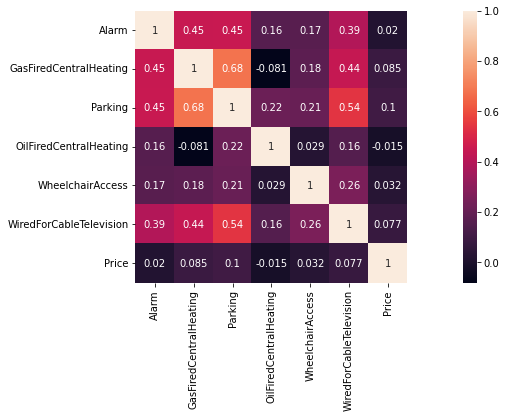

In [55]:
plt.figure(figsize=(20,5))
sns.heatmap(house_train[['Alarm','GasFiredCentralHeating','Parking','OilFiredCentralHeating','WheelchairAccess','WiredForCableTelevision','Price']].corr(), square=True, annot=True);

In [56]:
services = ['Services','Alarm','GasFiredCentralHeating','Parking','OilFiredCentralHeating','WheelchairAccess','WiredForCableTelevision']
house_train.drop(services, axis=1, inplace=True)
house_test.drop(services, axis=1, inplace=True)

The `Services` feature contains information about particular amenities or facilities available in every property, described as follow:
- Alarm
- GasFiredCentralHeating
- Parking
- OilFiredCentralHeating
- WheelchairAccess
- WiredForCableTelevision

They were preprocessed finding the correspondent service in the available information, to then adding a `Yes` or `No` to that service in the property. Next, they were mapped to its numerical value. Having in mind that ~64% of the data point are missing, this process removes them filling them with 0 to represent the no information about this value. Considering dropping variable, as even after preprocessing doesn't bring significant value to the evaluation. But very interesting to notice how Parking and Gas Fired Central Heating are the ones with the highest correlation to Price but not strong enough to keeo that feature, consequently dropping them all.



'Features' 

In [57]:
house_train['Features'].head()

0                                                 None
1    Bight and Spacious interior\nNumerous original...
2    Special Features\nLarge rear garden\nGenerous ...
3    Wonderful 3 bed detached bungalow.     \nAccom...
4    Detached Property      \nDouble Glazed Windows...
Name: Features, dtype: object

`Features` is Free text, that will be processed using NLP

'Latitude' & 'Longitude'

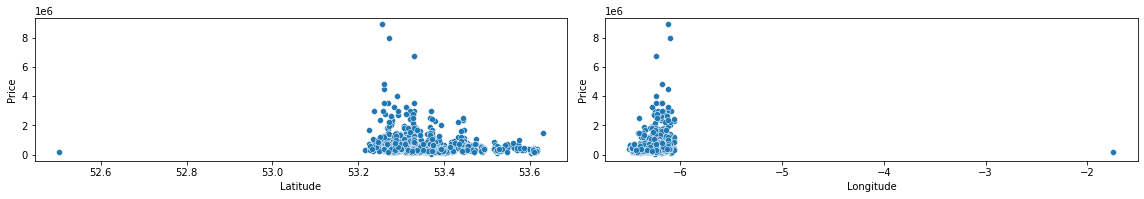

In [58]:
fig = plt.figure(figsize=(16,5))
fig.add_subplot(2,2,1)
sns.scatterplot(house_train['Latitude'],house_train['Price'])
fig.add_subplot(2,2,2)
sns.scatterplot(house_train['Longitude'],house_train['Price'])
plt.tight_layout()

In [59]:
# Removing location that are outside of Ireland 
house_train = house_train.drop(house_train[house_train['Latitude'] < 52].index)
house_train = house_train.drop(house_train[house_train['Longitude'] > -4].index)

house_test = house_test.drop(house_test[house_test['Latitude'] < 52].index)
house_test = house_test.drop(house_test[house_test['Longitude'] > -4].index)

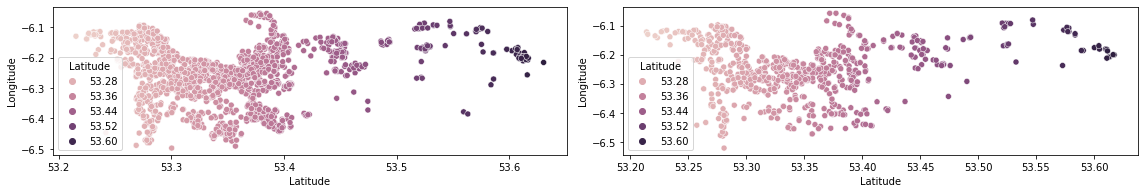

In [60]:
fig = plt.figure(figsize=(16,5))
fig.add_subplot(2,2,1)
sns.scatterplot(data=house_train,x='Latitude', y='Longitude', hue='Latitude')
fig.add_subplot(2,2,2)
sns.scatterplot(data=house_test,x='Latitude', y='Longitude', hue='Latitude')
plt.tight_layout()

For `Latitude` and `Longitude` we can see an outlier, dropped by removing data points < 52 and lower -4.

'Type'

In [61]:
house_train['Type'].value_counts()

semi-detached     457
apartment         431
terraced          299
detached          234
end-of-terrace    118
bungalow           48
duplex             33
townhouse          14
studio              2
site                1
Name: Type, dtype: int64

In [62]:
property_type_mapper = {
    "apartment": 1,
    "bungalow": 5,
    "detached": 9,
    "duplex": 2,
    "end-of-terrace": 6,
    "semi-detached": 8,
    "site": 3,
    "studio": 0,
    "terraced": 4,
    "townhouse": 7
}
house_train['Type'] = house_train['Type'].replace(property_type_mapper)
house_test['Type'] = house_test['Type'].replace(property_type_mapper)

Property Type was converted to numerical variables, replacing the 10 characters using a mapper

'Surface'

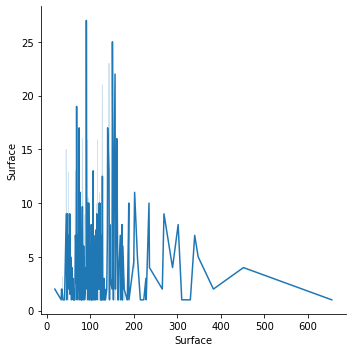

In [63]:
surface_counts = house_train['Surface'].value_counts()
sns.relplot(data=house_train, kind="line", x="Surface", y=surface_counts, facet_kws=dict(sharex=False));

In [64]:
house_train['Surface'].values[house_train['Surface'].values > 350] = 353
house_test['Surface'].values[house_test['Surface'].values > 350] = 350

`Surface` was reconfigured to remove the outliers, having all a max of 350 sqm per property

<Figure size 1440x589320 with 0 Axes>

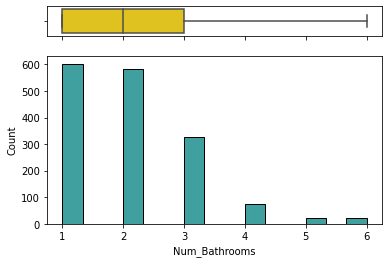

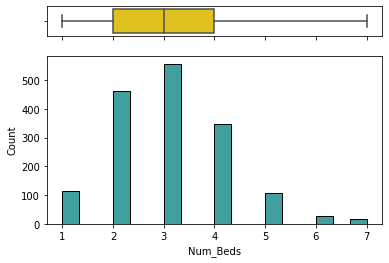

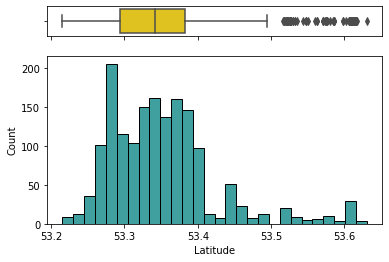

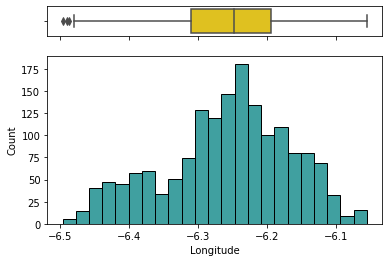

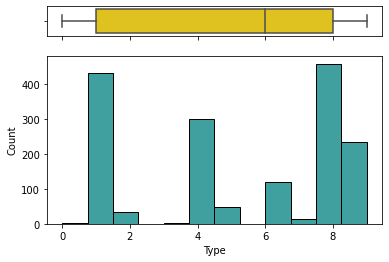

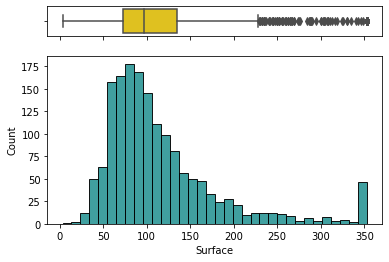

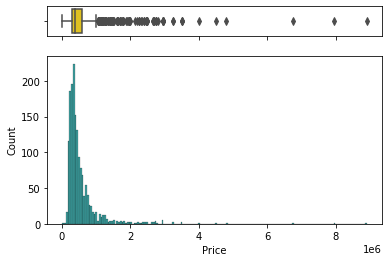

In [65]:
# Representation of the summary of the set of data values 
features = house_train.drop(['Index','Description', 'Features'], axis=1)
fig = plt.figure(figsize=(20,(len(features))*5))
sns.color_palette("viridis", as_cmap=True)
for i in features: 
  # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
  f, (ax_box, ax_hist) = plt.subplots(2,1, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
  
  # assigning a graph to each ax
  sns.boxplot(house_train[i], ax=ax_box, color="gold")
  sns.histplot(data=house_train, x=i, ax=ax_hist, color="teal")
  
  # Remove x axis name for the boxplot
  ax_box.set(xlabel='')

plt.show();

In [66]:
# Missing Values
print('Train Data Missing Values')
print(house_train.isna().sum())
print('')
print('Test Data Missing Values')
print(house_test.isna().sum())

Train Data Missing Values
Index            0
Num_Bathrooms    0
Num_Beds         0
Description      0
Features         0
Latitude         0
Longitude        0
Type             0
Surface          0
Price            0
dtype: int64

Test Data Missing Values
Index            0
Num_Bathrooms    0
Num_Beds         0
Description      0
Features         0
Latitude         0
Longitude        0
Type             0
Surface          0
dtype: int64


In [67]:
house_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1637 entries, 0 to 1637
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          1637 non-null   int64  
 1   Num_Bathrooms  1637 non-null   int64  
 2   Num_Beds       1637 non-null   int64  
 3   Description    1637 non-null   object 
 4   Features       1637 non-null   object 
 5   Latitude       1637 non-null   float64
 6   Longitude      1637 non-null   float64
 7   Type           1637 non-null   int64  
 8   Surface        1637 non-null   float64
 9   Price          1637 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 220.7+ KB


In [68]:
house_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          702 non-null    int64  
 1   Num_Bathrooms  702 non-null    int64  
 2   Num_Beds       702 non-null    int64  
 3   Description    702 non-null    object 
 4   Features       702 non-null    object 
 5   Latitude       702 non-null    float64
 6   Longitude      702 non-null    float64
 7   Type           702 non-null    int64  
 8   Surface        702 non-null    float64
dtypes: float64(3), int64(4), object(2)
memory usage: 74.8+ KB


In [69]:
house_train.describe()

,Index,Num_Bathrooms,Num_Beds,Latitude,Longitude,Type,Surface,Price
count,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1.637000e+03
mean,819.783140,2.027489,3.017715,53.350991,-6.257841,5.194869,116.602035,5.549369e+05
std,472.999846,1.058140,1.171296,0.073934,0.091825,3.079512,67.141978,5.653074e+05
min,1.000000,1.000000,1.000000,53.215381,-6.497000,0.000000,3.400000,1.999500e+04
25%,411.000000,1.000000,2.000000,53.294340,-6.309640,1.000000,73.000000,2.950000e+05
50%,820.000000,2.000000,3.000000,53.341510,-6.247821,6.000000,97.100000,3.950000e+05
75%,1229.000000,3.000000,4.000000,53.382053,-6.194319,8.000000,135.000000,5.950000e+05
max,1638.000000,6.000000,7.000000,53.630588,-6.054719,9.000000,353.000000,8.900000e+06


In [70]:
house_test.describe()

,Index,Num_Bathrooms,Num_Beds,Latitude,Longitude,Type,Surface
count,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000
mean,1989.500000,2.022792,2.975783,53.350445,-6.252411,5.047009,117.363473
std,202.794231,1.049173,1.128409,0.073961,0.091600,3.070603,68.450749
min,1639.000000,1.000000,1.000000,53.214227,-6.521183,1.000000,32.100000
25%,1814.250000,1.000000,2.000000,53.295225,-6.304258,1.000000,73.000000
50%,1989.500000,2.000000,3.000000,53.341153,-6.247799,5.000000,99.200000
75%,2164.750000,3.000000,4.000000,53.381752,-6.184277,8.000000,136.875000
max,2340.000000,6.000000,7.000000,53.617443,-6.057150,9.000000,350.000000


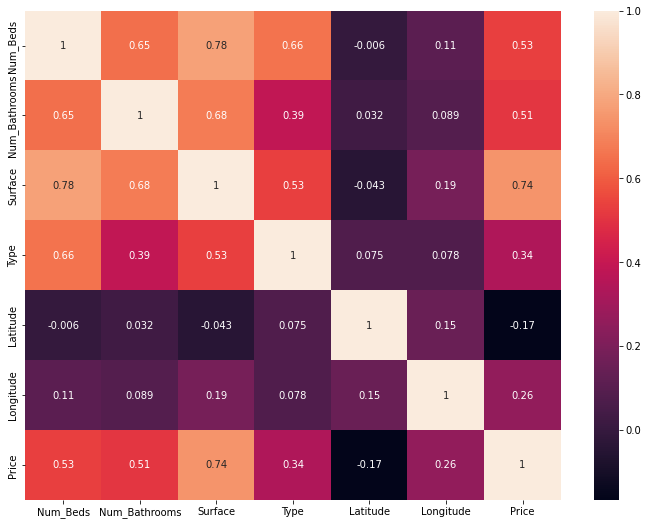

In [71]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(house_train[['Num_Beds','Num_Bathrooms','Surface','Type','Latitude','Longitude','Price']].corr(), annot=True)
plt.show()

Final selection of features with the strongest correlation with Price goes to Number of Bedrooms, Number of Bathrooms, Surface, Type of property, Latitude and Longitude

# NATURAL LANGUAGE PROCESSING

Natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) is a subfield of linguistics, computer science, and artificial intelligence.

* NLP concerned with the interactions between computers and human language.
* In particular how to program computers to process and analyze large amounts of natural language data. 
* The goal is a computer capable of "understanding" the contents of documents.
* Including the contextual nuances of the language within them. 
* The technology can then accurately extract information and insights contained in the documents.
* As well as categorize and organize the documents themselves. 

Reference:
- Di Pietro, M., 2020. Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT. [online] Medium. Available at: <https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794> [Accessed 15 October 2021].

In [72]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [73]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and   
    ## characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
             
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    # remove all numeric values from strings
    lst_text = [re.sub('[^a-zA-Z]', ' ', sentence) for sentence in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [74]:
nlp_train = house_train[['Description', 'Features', 'Price']]
nlp_test = house_test[['Description', 'Features']]

In [75]:
nlp_train["Description_clean"] = nlp_train["Description"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

In [76]:
nlp_train["Features_clean"] = nlp_train["Features"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

In [77]:
nlp_test["Description_clean"] = nlp_test["Description"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

In [78]:
nlp_test["Features_clean"] = nlp_test["Features"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

In [79]:
nlp = nlp_train[['Description_clean','Features_clean','Price']]
nlp.head(5) 

,Description_clean,Features_clean,Price
0,dng delighted present market chipping row tw...,none,195000
1,northbrook terrace charming red brick perio...,bight spacious interior numerous original feat...,425000
2,welcome cotter close immaculately presented ...,special feature large rear garden generous str...,535000
3,welcome sycamore walk enjoying premier addre...,wonderful bed detached bungalow accommodatio...,499000
4,four season come market wonderful opportunity ...,detached property double glazed window ofch do...,510000


In [80]:
nlp.isna().sum()

Description_clean    0
Features_clean       0
Price                0
dtype: int64

## TF-IDF
Value of a word increases proportionally to count, but it is inversely proportional to the frequency of the word in the corpus.

In [81]:
## split dataset
dtf_train, dtf_test = train_test_split(nlp, test_size=0.3)
## get target
y_train_nlp = dtf_train["Price"].values
y_test_nlp = dtf_test["Price"].values

In [82]:
# Tf-Idf (advanced variant of BoW)
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [83]:
## use the vectorizer on the preprocessed corpus of the train set to extract a 
## vocabulary and create the feature matrix
corpus = dtf_train["Description_clean"]
X_train_nlp = vectorizer.fit_transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [84]:
def fit_bow(corpus, vectorizer=None, vocabulary=None):
    ## vectorizer
    vectorizer = feature_extraction.text.TfidfVectorizer(max_features=None, ngram_range=(1,1), vocabulary=vocabulary) if vectorizer is None else vectorizer
    vectorizer.fit(corpus)
    
    ## sparse matrix
    print("--- creating sparse matrix ---")
    X = vectorizer.transform(corpus)
    print("shape:", X.shape)
    
    ## vocabulary
    print("--- creating vocabulary ---") if vocabulary is None else print("--- used vocabulary ---")
    dic_vocabulary = vectorizer.vocabulary_   #{word:idx for idx, word in enumerate(vectorizer.get_feature_names())}
    print(len(dic_vocabulary), "words")
    
    ## text2tokens
    print("--- tokenization ---")
    tokenizer = vectorizer.build_tokenizer()
    preprocessor = vectorizer.build_preprocessor()
    lst_text2tokens = []
    for text in corpus:
        lst_tokens = [dic_vocabulary[word] for word in tokenizer(preprocessor(text)) if word in dic_vocabulary]
        lst_text2tokens.append(lst_tokens)
    print(len(lst_text2tokens), "texts")
    
    ## plot heatmap
    fig, ax = plt.subplots(figsize=(15,5))
    sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title('Sparse Matrix Sample')
    plt.show()
    return {"X":X, "lst_text2tokens":lst_text2tokens, "vectorizer":vectorizer, "dic_vocabulary":dic_vocabulary, "X_names":vectorizer.get_feature_names()}

--- creating sparse matrix ---
shape: (1145, 10000)
--- creating vocabulary ---
10000 words
--- tokenization ---
1145 texts


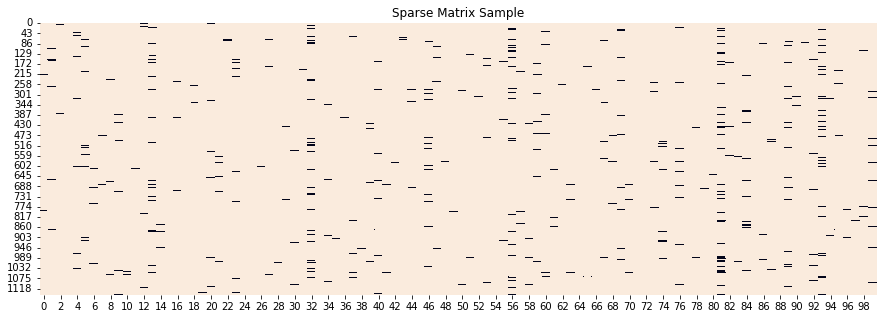

In [85]:
dic_bow = fit_bow(corpus=dtf_train["Description_clean"], vectorizer=vectorizer, vocabulary=None)
X_train_nlp, X_names, vectorizer, dic_vocabulary, lst_text2tokens = dic_bow["X"], dic_bow["X_names"], dic_bow["vectorizer"], dic_bow["dic_vocabulary"], dic_bow["lst_text2tokens"]

In [86]:
# perform a Chi-Square test to determine whether a feature and the (binary) target are independent
# keep only the features with a certain p-value from the Chi-Square test
y_nlp = dtf_train["Price"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y_nlp):
    chi2, p = feature_selection.chi2(X_train_nlp, y_nlp==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [87]:
for cat in np.unique(y_nlp):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# 19995:
  . selected features: 36
  . top features: delivered,low energy,shown,reduce,require,brought,carbon,footprint,weather,survey
 
# 100000:
  . selected features: 46
  . top features: healy delighted,pub shop,seaside,dng mckenna,healy,mckenna,mckenna healy,distance dublin,convenient skerries,rush
 
# 125000:
  . selected features: 42
  . top features: room cum,room hallway,loungedining room,surround wc,millfield,millfield shopping,intersection,restaurant amp,throughout apartment,cum kitchen
 
# 148000:
  . selected features: 39
  . top features: ongar,center,local community,ongar village,throughout would,away city,choice national,city center,industrial,property delighted
 
# 155000:
  . selected features: 34
  . top features: reach local,new laminate,location mature,mature amp,property recently,location location,brand,st time,flooring range,foothill dublin
 
# 159000:
  . selected features: 47
  . top features: take st,located ground,new nangor,hallway generous,space viewing,are

In [88]:
## refit the vectorizer on the corpus by giving this new set of words as input
## smaller feature matrix and a shorter vocabulary
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train_nlp = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

--- creating sparse matrix ---
shape: (1145, 5834)
--- creating vocabulary ---
5834 words
--- tokenization ---
1145 texts


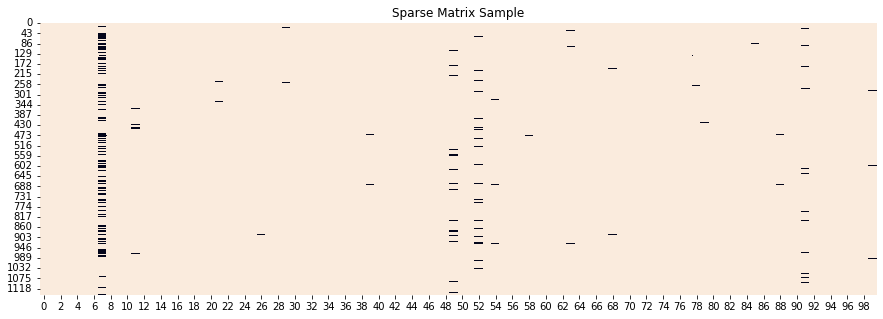

In [89]:
dic_bow = fit_bow(corpus=dtf_train["Description_clean"], vectorizer=vectorizer, vocabulary=None)
X_train_nlp, X_names, vectorizer, dic_vocabulary, lst_text2tokens = dic_bow["X"], dic_bow["X_names"], dic_bow["vectorizer"], dic_bow["dic_vocabulary"], dic_bow["lst_text2tokens"]

In [90]:
## Bayes’ Theorem, a rule that uses probability to make predictions based on 
## prior knowledge of conditions that might be related
classifier = MultinomialNB()

## pipeline
model = Pipeline([("vectorizer", vectorizer),
                  ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train_nlp, y_train_nlp)
## test
X_test_nlp = dtf_test["Description_clean"].values
predicted = model.predict(X_test_nlp)
predicted_prob = model.predict_proba(X_test_nlp)

In [91]:
classes = np.unique(y_test_nlp)

## Accuracy
accuracy = accuracy_score(y_test_nlp, predicted)
print("Accuracy:",  round(accuracy,5))

Accuracy: 0.02642


Cleansing process of the free-text features within the dataset, in this case Description and Features, for train and test consisted in:
* Lower String
* Remove Punctuation with regex expression [^\w\s]
* Tokenize strings to remove Stop Words using NLTK list
* Stemming to remove -ing, -ly words OR
* Lemmatisation to convert the word into root wor
* Remove all numeric values from strings [^a-zA-Z]
- After all of the preprocessing aforementioned,  TF-IDF (Term Frequency — Inverse Dense Frequency) was applied, in order to find meaning of sentences. Tested for both cases, Features and Description, and for none of them Accuracy gives good results.



# FEATURE IMPORTANCE

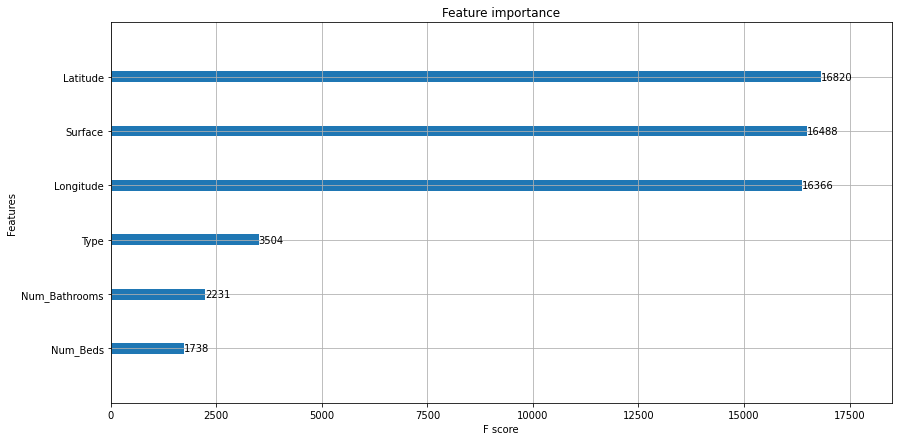

In [92]:
# Feature selection using XGBoost[1]
from xgboost import XGBClassifier
from xgboost import plot_importance

#Remove Categorical Variables
house_train_fi = house_train.drop(['Index','Description','Features'], axis=1)
# For train/test split
X_fi = house_train_fi.drop('Price',axis=1)
y_fi = house_train_fi['Price']
X_train_fi,X_test_fi,y_train_fi,y_test_fi = train_test_split(X_fi, y_fi, test_size=0.3)
fi_Model = XGBClassifier()
fi_Model.fit(X_train_fi, y_train_fi)
# plot feature importance
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(fi_Model)
plt.show();

Feature Importance based on XGBoost tell us that surface, latitude and longitude are the top most important features to predict the property prices, followed by number of beds and number of bathrooms, that interesting enough were the two features with high correlation against price.

# MODEL

## Training & Test Data

In [93]:
X = house_train.drop(['Price','Description','Features'], axis=1).values
y = house_train['Price'].values
X_test = house_test.drop(['Description','Features'], axis=1).values

# training: 70% (0.7), test: 30% (0.3) 
Xs_train,Xs_test,ys_train,ys_test = train_test_split(X, y, test_size=0.3)

In [94]:
X

array([[ 1.000000e+00,  2.000000e+00,  2.000000e+00, ..., -6.438791e+00,
         1.000000e+00,  6.700000e+01],
       [ 2.000000e+00,  1.000000e+00,  2.000000e+00, ..., -6.239779e+00,
         4.000000e+00,  9.597000e+01],
       [ 3.000000e+00,  3.000000e+00,  3.000000e+00, ..., -6.222771e+00,
         8.000000e+00,  1.070000e+02],
       ...,
       [ 1.636000e+03,  2.000000e+00,  3.000000e+00, ..., -6.435278e+00,
         8.000000e+00,  9.800000e+01],
       [ 1.637000e+03,  6.000000e+00,  7.000000e+00, ..., -6.221030e+00,
         9.000000e+00,  3.530000e+02],
       [ 1.638000e+03,  2.000000e+00,  2.000000e+00, ..., -6.125022e+00,
         8.000000e+00,  5.000000e+01]])

In [95]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

Xss_final_test = np.hstack([X_test,X_test[:,[2]]**2])
Xn_final_test = xscaler.transform(Xss_final_test)

ylog = np.log(ys_train.reshape(-1, 1).astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

## Piecewise Regression

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

### Baseline Model

In [96]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 879.9


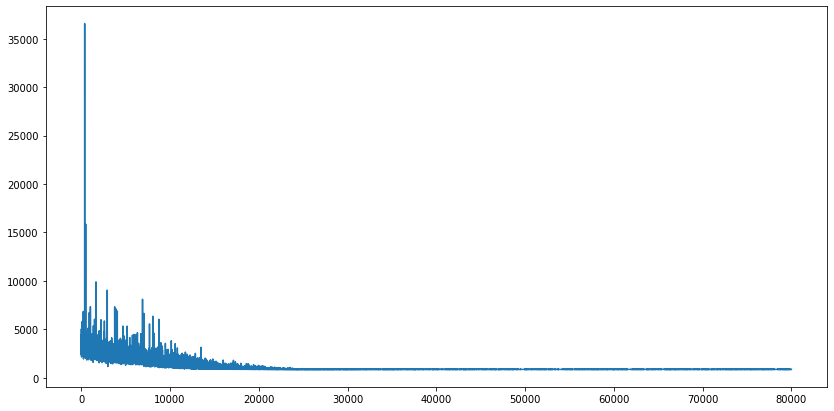

In [97]:
#number of iterations of the algorithms
iter = 80000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [98]:
# samples from the posterior
posterior = approximation.sample(5000)

In [99]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BM = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BM - ys_test))))
print("MAPE = ",(np.mean(abs(y_pred_BM - ys_test) / ys_test)))

MAE =  138441.5584391882
MAPE =  0.21359059623485788


In [100]:
# Save prediction to file
y_pred_out = np.exp(yscaler.inverse_transform(y_pred_BM))
results = sample_submission['Index']
BM_results = pd.DataFrame(y_pred_out, columns=['Price'])
BM = pd.concat([results, BM_results], axis=1)
BM.to_csv('samplesubmission_v8.csv',index=False)

In [101]:
files.download('samplesubmission_v8.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Clustering

Full Model

In [102]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

from sys import maxsize
from numpy import set_printoptions

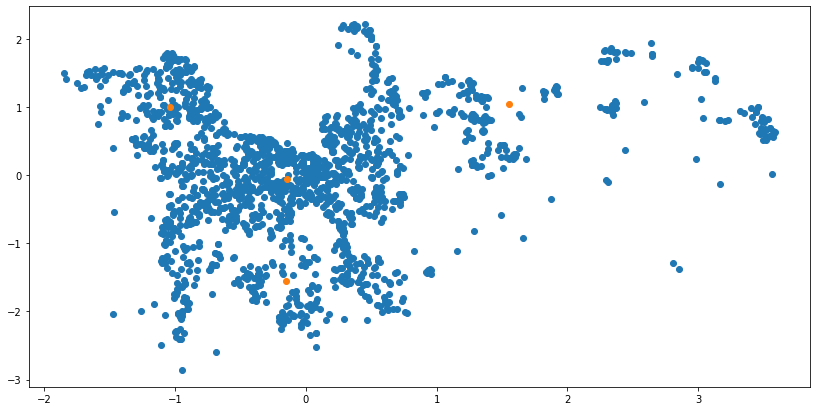

1847

In [103]:
gmm = GaussianMixture(n_components=4)
# clustering by features 3, 4 (latitude & longitude)
ind=[3,4]
X_ind = np.vstack([Xn_train[:,ind],Xn_final_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])
plt.show()
len(X_ind)

Clusters

In [104]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 569, 1: 189, 2: 173, 3: 214}

In [105]:
# test clusters
clusters_test = gmm.predict(Xn_final_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 360, 1: 112, 2: 116, 3: 114}

In [106]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_final_test[clusters_test==0,:]

ylog0 = np.log(ys_train.reshape(-1, 1).astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [107]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_final_test[clusters_test==1,:]
ylog1 = np.log(ys_train.reshape(-1, 1).astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [108]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_final_test[clusters_test==2,:]
ylog2 = np.log(ys_train.reshape(-1, 1).astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [109]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_final_test[clusters_test==3,:]
ylog3 = np.log(ys_train.reshape(-1, 1).astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

Models

In [110]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 449.52


In [111]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 180.46


In [112]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 156.28


In [113]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 190.25


In [114]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

Simulations

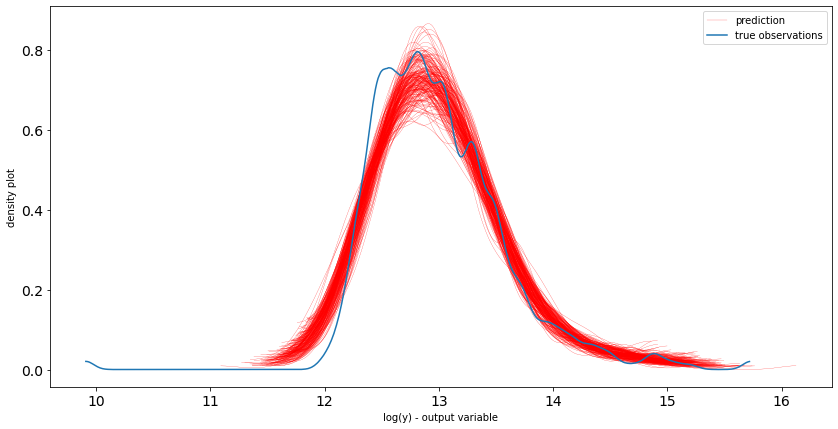

In [115]:
# Only Cluster 0
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

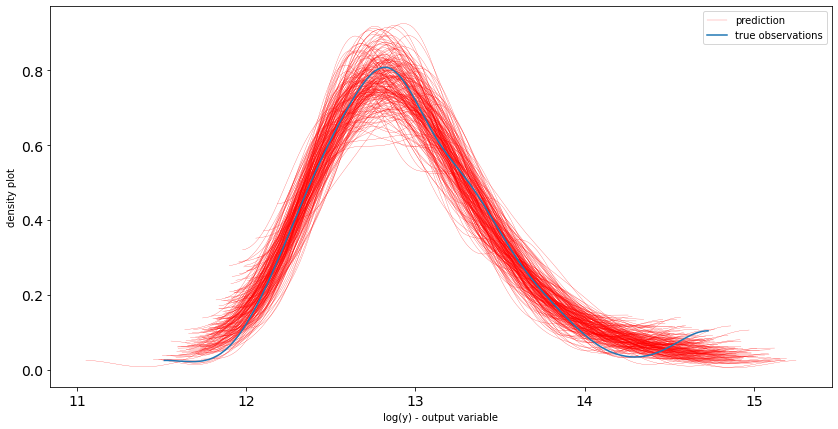

In [116]:
# Only Cluster 1
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");


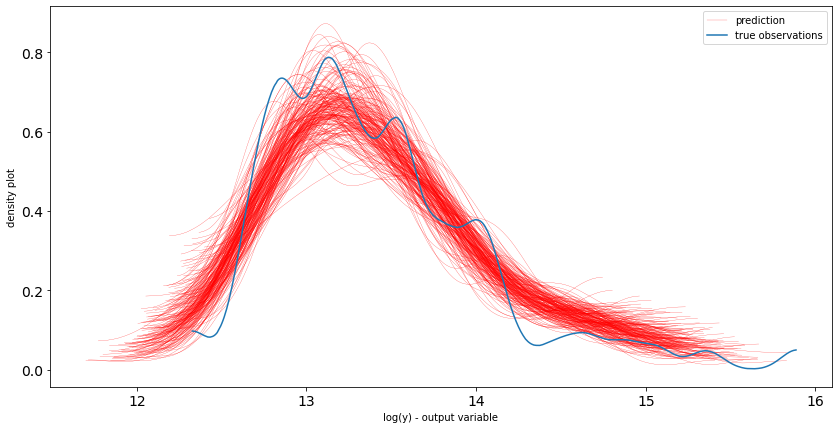

In [117]:
# Only Cluster 2
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

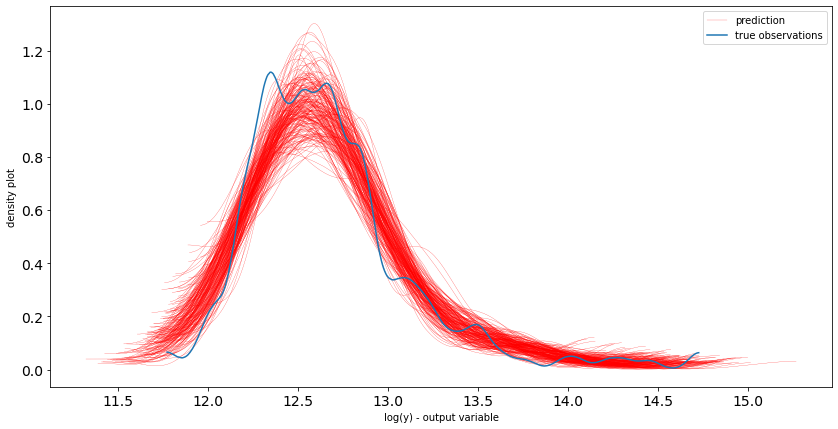

In [118]:
# Only Cluster 3
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

Overall

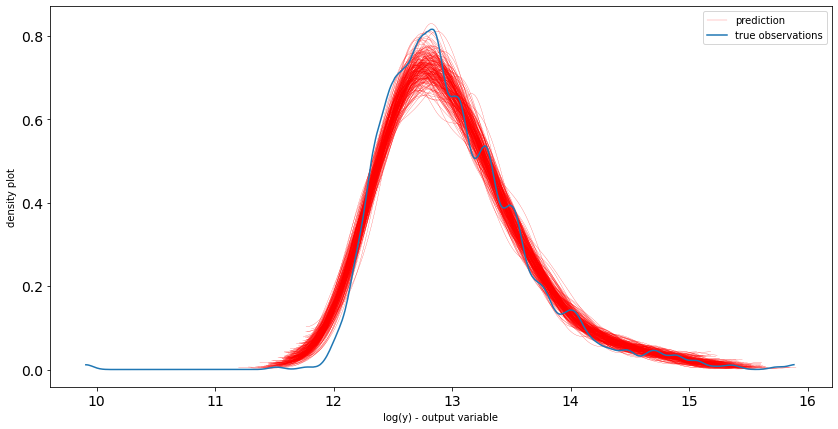

In [119]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

Test set performance

In [120]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))

joint_y_pred_BLR=np.hstack([y_pred_BLR0, y_pred_BLR1, y_pred_BLR2, y_pred_BLR3])

In [121]:
#y_pred_BLR_piecewise = np.exp(yscaler.inverse_transform(joint_y_pred_BLR))
results = sample_submission['Index']
Piecewise_results = pd.DataFrame(joint_y_pred_BLR, columns=['Price'])
Piecewise = pd.concat([results, Piecewise_results], axis=1)
Piecewise.to_csv('samplesubmission_v9.csv',index=False)

In [122]:
files.download('samplesubmission_v9.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPC on the Test set

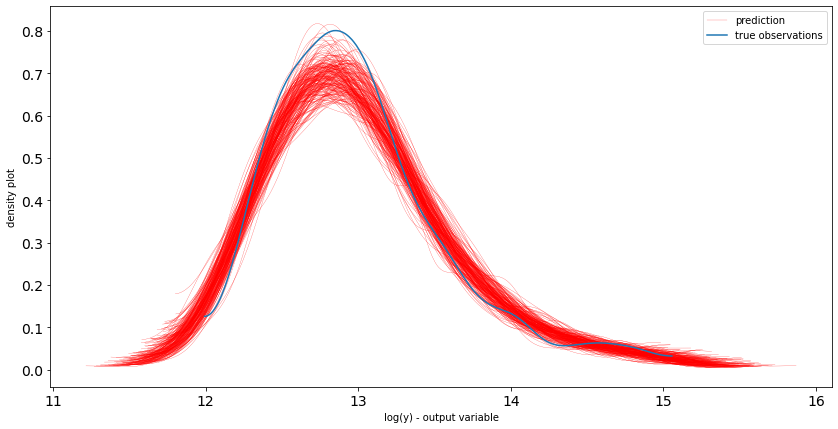

In [123]:
## Posterior predictive checks (PPCs)
num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(joint_y_pred_BLR),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Bayesian NN

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

In [124]:
# https://theano-pymc.readthedocs.io/en/latest/
import theano

# add a column of ones to include an intercept in the model
x1 = np.hstack([np.ones((Xn_train.shape[0],1)), Xn_train])
floatX = theano.config.floatX

l = 15
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)

# pymc3 model as neural_network
with pm.Model() as neural_network:
    # we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', yn_train)
    # Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1', 0, sigma=1,
                             shape=(x1.shape[1], l), testval=init_1)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_0', 0, sigma=1,
                              shape=(l,),testval=init_out)

    # Build neural-network using tanh activation function
    # Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
    # Linear layer, like in Linear regression
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))

    # standard deviation of noise
    sigma = pm.HalfCauchy('sigma',5)

    # Normal likelihood
    out = pm.Normal('out',
                       act_out,
                       sigma=sigma,
                       observed=ann_output[:,0])

In [125]:
# some parameters
par1 = 100  # start with 100, then use 1000+
par2 = 1000 # start with 1000, then use 10000+

# neural network
with neural_network:
    posterior = pm.sample(par1,tune=par2,chains=1)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, w_0, w_1]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 454 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [126]:
# we can do instead an approximated inference
param3 = 1000 # start with 1000, then use 50000+
VI = 'advi'  # 'advi', 'fullrank_advi', 'svgd', 'asvgd', 'nfvi'
OP = pm.adam # pm.adam, pm.sgd, pm.adagrad, pm.adagrad_window, pm.adadelta
LR = 0.01    

with neural_network:
    approx = pm.fit(param3, method=VI, obj_optimizer=pm.adam(learning_rate=LR))

Finished [100%]: Average Loss = 2,426


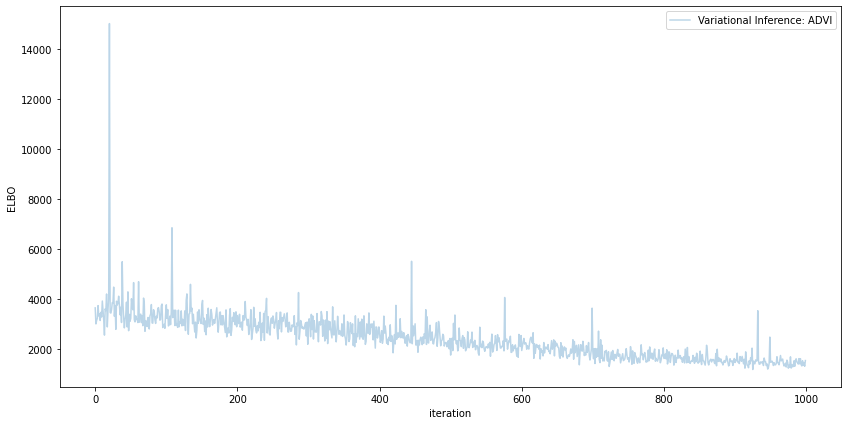

In [127]:
# plot 
pb.plot(approx.hist, label='Variational Inference: '+ VI.upper(), alpha=.3)
pb.legend(loc='upper right')
# Evidence Lower Bound (ELBO)
# https://en.wikipedia.org/wiki/Evidence_lower_bound
pb.ylabel('ELBO')
pb.xlabel('iteration');

In [128]:
# draw samples from variational posterior
D = 500
posterior = approx.sample(draws=D)

Model on validation data set

In [129]:
# add a column of ones to include an intercept in the model
x2 = np.hstack([np.ones((Xn_test.shape[0],1)), Xn_test])
y_final_pred = []
for i in range(posterior['w_1'].shape[0]):
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x2.T))
    #outer layer
    y_final_pred.append(np.dot(posterior['w_0'][i,:],t1))

# predictions   
y_final_pred = np.array(y_final_pred).mean(axis=0)

In [130]:
#Inverse transformation / scaling 
y_val_pred_final = np.exp(yscaler.inverse_transform(y_final_pred))

In [132]:
print("MAE = ",(np.mean(abs(y_val_pred_final - ys_test))))
print("MAPE = ",(np.mean(abs(y_val_pred_final - ys_test) / ys_test)))

MAE =  176775.55537397342
MAPE =  0.24003038806705757


In [133]:
# final predictions
# add a column of ones to include an intercept in the model
x2 = np.hstack([np.ones((Xn_test.shape[0],1)), Xn_test])
#x2 = np.vstack([np.ones(len(X_new_test)), X_new_test]).T

y_pred = []
for i in range(posterior['w_1'].shape[0]):
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x2.T))
    #outer layer
    y_pred.append(np.dot(posterior['w_0'][i,:],t1))

# predictions   
y_pred = np.array(y_pred).mean(axis=0)

In [136]:
y_pred_out = np.exp(yscaler.inverse_transform(y_pred))
results = sample_submission['Index']
BayesianNN_results = pd.DataFrame(y_pred_out, columns=['Price'])
BayesianNN = pd.concat([results, BayesianNN_results], axis=1)
BayesianNN.to_csv('samplesubmission_v10.csv',index=False)

In [137]:
files.download('samplesubmission_v10.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# SUMMARY

- The data consists in two datasets, train and test House Data, with 1638 by 13 vs 702 by 12 respectively. Only difference in columns numbers is the Price, as in this case is our target predictor. Information provided by the features include location, number of bathrooms and beds, BER class, description of the property, services, lat and long, type of property, size through surface and price. A column ID was dropped at loading data stage as it is another property identifier, as well as Index, and the former is the one used to recognize properties in the sample submission file, reason why it was kept.
- NLP section, a cleansing process of the free-text features such as Descriptions and Features was done, for train and test consisted in, Lower String, Remove Punctuation with regex expression [^\w\s], Tokenize strings to remove Stop Words using NLTK list, Stemming to remove -ing, -ly words OR Lemmatisation to convert the word into root words and Removing all numeric values from strings [^a-zA-Z], to proceed to the implementation of TF-IDF, where a value of a word increases proportionally to count, but it is inversely proportional to the frequency of the word in the corpus.
- After all of the preprocessing aforementioned,  TF-IDF (Term Frequency — Inverse Dense Frequency) was applied, in order to find meaning of sentences. Tested for both cases, Features and Description, and for none of them Accuracy gives good results.
- Feature Importance based on XGBoost was implemented and told us that surface, latitude and longitude are the top most important features to predict the property prices, followed by number of beds and number of bathrooms, that interesting enough were the two features with high correlation against price.
- 
Advanced Machine Learning Methods used:

**Base Model: Linear Regression**
- MAE =  138441.5584391882
- MAPE =  0.21359059623485788

**Bayesian NN**
- MAE =  176775.55537397342
- MAPE =  0.24003038806705757